# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [ ] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [ ] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

## Датасет

In [393]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, recall_score
from sklearn.utils.validation import check_array
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.special import expit

sns.set_style('ticks')
sns.set_palette("viridis")

warnings.filterwarnings('ignore')

In [394]:
data = pd.read_csv('/kaggle/input/heartdisease/heart.csv')

Признаки:
- age - возраст
- sex - пол (1 = мужчина; 0 = женщина)
- cp - тип боли в груди
- trestbps - артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в больницу)
- chol - уровень холестерина в мг/дл
- fbs - уровень сахара в крови натощак > 120 мг/дл (1 = верно; 0 = ложно)
- restecg - результаты электрокардиографии в покое
- thalach - максимальная частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
- oldpeak - депрессия сегмента ST, вызванная физической нагрузкой, относительно состояния покоя
- slope - наклон пикового сегмента ST при максимальной физической нагрузке
- ca - количество крупных сосудов (0-3), окрашенных при флюороскопии
- thal - 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект
- target - есть заболевание или нет (1=да, 0=нет)

Целевой признак - target

# Разведочный анализ данных (EDA)

In [395]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [396]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Как можно заметить, пустых значений нет

In [397]:
data.duplicated().sum()

723

In [398]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [399]:
data.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

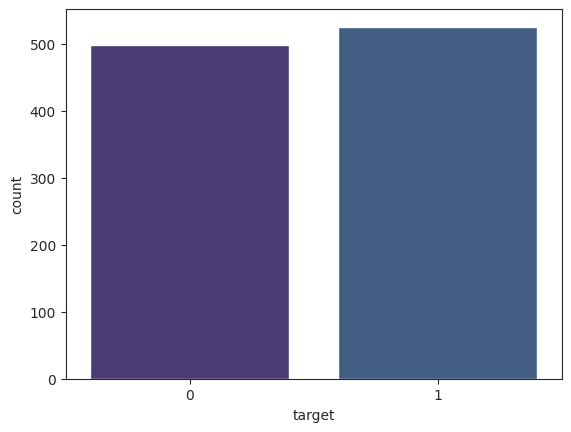

In [400]:
sns.countplot(x = data.target)
plt.show()

Датасет довольно сбалансирован, заболевших и здоровых примерно поровну.

Посмотрим на распределение больных по возрасту и по полу.

<Axes: xlabel='target', ylabel='age'>

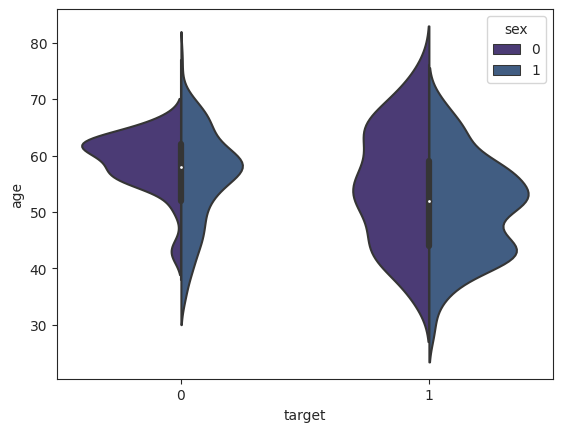

In [401]:
sns.violinplot(x="target", y="age", hue="sex", data=data, split=True)

Средний возраст переживающих сердечные приступы среди женщин в датасете выше, чем у мужчин. У женщин заболеваемость в основном происходит в районе 50 лет, у мужчин же в районе 45 и 53. Скорее всего, это ошибка выборки, и заболеваемость для мужчин должна тоже равномерно увеличиваться до ~50 лет, а после убывать.

Также наибольшее число здоровых людей - в районе 60 лет, что довольно неожиданно.

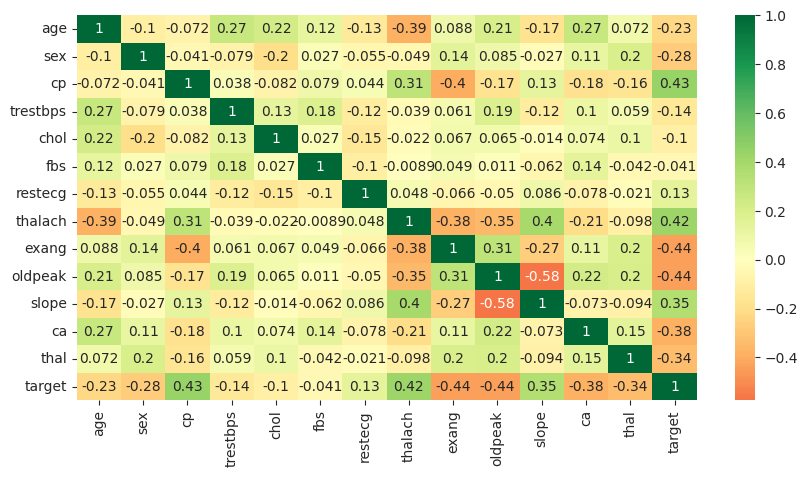

In [402]:
sns.heatmap(data.corr(), center=0, annot=True, cmap="RdYlGn")
fig = plt.gcf()
fig.set_size_inches(10, 5)

Больше всего на заболеваемость влияют стенокардия, депрессия сегмента ST, тип боли в груди и максимальная частота сердечных сокращений.

# Реализация алгоритмов классификации

In [403]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self, alpha = 1, *, max_iter = 1000, tol = 1e-4, eta = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta

    def _fit_binary(self, X, y):
        coefs = np.zeros(X.shape[1])
        grad = np.inf
        n_iter = 0
        while n_iter < self.max_iter and np.linalg.norm(grad) > self.tol:
            pred = expit(X @ coefs)
            grad = X.T @ (pred - y) + 2 * self.alpha * np.pad(coefs[:-1], (0, 1))
            n_iter += 1
            coefs -= grad * self.eta / n_iter

        return coefs[:-1], coefs[-1], n_iter

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])
        self.coefs_ = np.empty((self.classes_.size, self.n_features_in_))
        self.intercept_ = np.empty((self.classes_.size,))
        self.n_iter_ = np.empty((self.classes_.size,))
        for i, c in enumerate(self.classes_):
            self.coefs_[i], self.intercept_[i], self.n_iter_[i] = self._fit_binary(X, y == c)

        return self

    def predict(self, X):
        X = check_array(X)
        class_probs = expit(X @ self.coefs_.T + self.intercept_)
        most_likely_class_idx = np.argmax(class_probs, axis=1)
        return self.classes_[most_likely_class_idx]

In [404]:
class MyKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors = 3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_, self.y_ = X, y
        return self

    def predict(self, X):
        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        
        for i, x in enumerate(X): 
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            n_neighbor_classes = self.y_[sorted_dists_idx][:self.n_neighbors]
            ns, counts = np.unique(n_neighbor_classes, return_counts=True)
            result[i] = ns[np.argmax(counts)]

        return result

## Обучение моделей без кросс валидации

In [405]:
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=69)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

model = MyLogisticRegression()
model.fit(X_train, y_train)
print("MyLogisticRegression algorithm")
print("Recall test:")
print(recall_score(model.predict(X_test), y_test))
print("Recall train:")
print(recall_score(model.predict(X_train), y_train))

MyLogisticRegression algorithm
Recall test:
0.9090909090909091
Recall train:
0.8869565217391304


In [406]:
model = MyKNeighborsClassifier()
model.fit(X_train, y_train)
print("Recall train:")
print(recall_score(y_train, model.predict(X_train)))
print("Recall test:")
print(recall_score(y_test, model.predict(X_test)))

Recall train:
0.9978540772532188
Recall test:
0.9666666666666667


## Обучение с кросс валидацией

Best params: {'estimator__n_neighbors': 1}
Best score: 0.9827956989247312


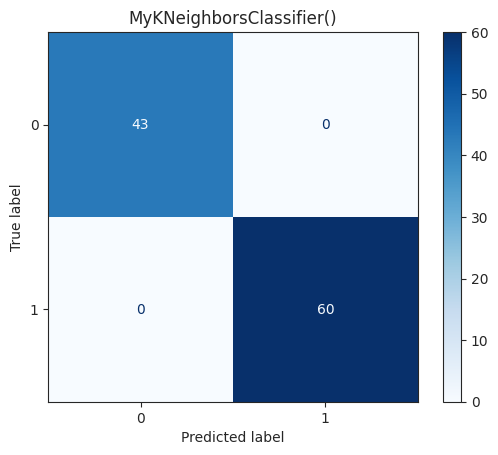

In [407]:
def train_and_print(estimator, param_grid, scoring):
    model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator)])
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}
    grid_search = GridSearchCV(
        model,
        param_grid,
        scoring=scoring
    )
    grid_search.fit(X_train, y_train)
    print("Best params: " + str(grid_search.best_params_))
    print('Best score:', grid_search.best_score_)

    ax = ConfusionMatrixDisplay.from_estimator(
            grid_search.best_estimator_,
            X_test,
            y_test,
            cmap="Blues",
        ).ax_
    ax.set_title(estimator)
    ax.plot()

In [ ]:
train_and_print(
    MyKNeighborsClassifier(), 
    {
        "n_neighbors": [i for i in range(1, 10, 1)]
    }, 
    "recall"
)

Best params: {'estimator__alpha': 0.0001, 'estimator__eta': 0.001, 'estimator__max_iter': 1000.0}
Best score: 0.9077327842598948


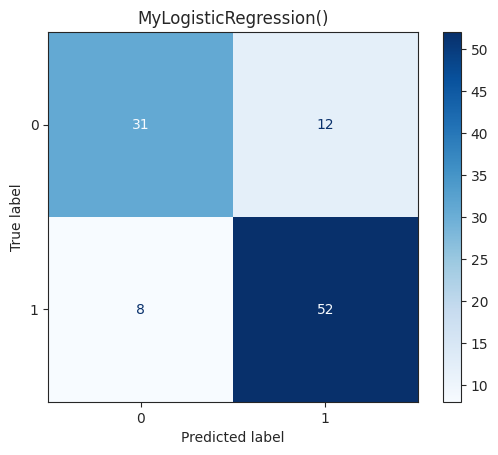

In [408]:
train_and_print(
    MyLogisticRegression(),
    {
        "eta": [1e-4, 1e-3, 1e-2],
        "alpha": [1e-4, 1e-3, 1e-2],
        "max_iter": [1e1, 1e2, 1e3],
    },
    "recall"
)

Best params: {'estimator__C': 0.0001, 'estimator__max_iter': 10, 'estimator__tol': 1e-07}
Best score: 0.9506520247083048


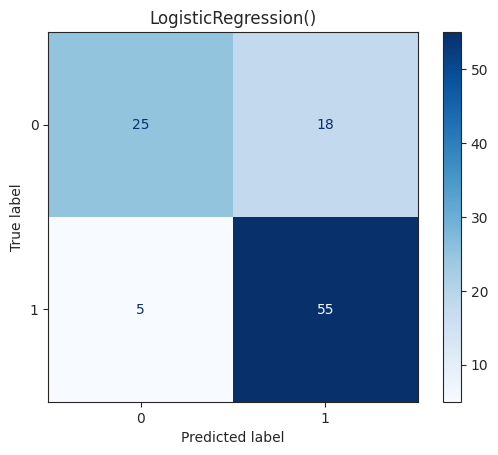

In [409]:
train_and_print(
    LogisticRegression(),
    {
        "tol": [1e-7, 1e-6, 1e-5, 1e-4],
        "C": [1e-4, 1e-3, 1e-2],
        "max_iter": [1, 10, 100],
    },
    "recall"
)

Best params: {'estimator__C': 1, 'estimator__coef0': 0, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear', 'estimator__tol': 1e-06}
Best score: 0.8488486431773777


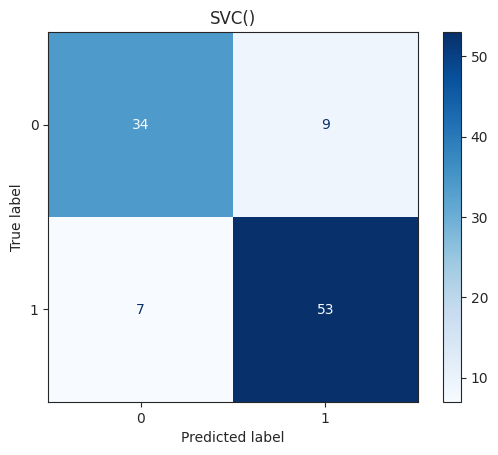

In [410]:
train_and_print(
    SVC(),
    {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-6, 1e-4],
    },
    "f1"
)

Best params: {'estimator__n_neighbors': 1}
Best score: 0.9827956989247312


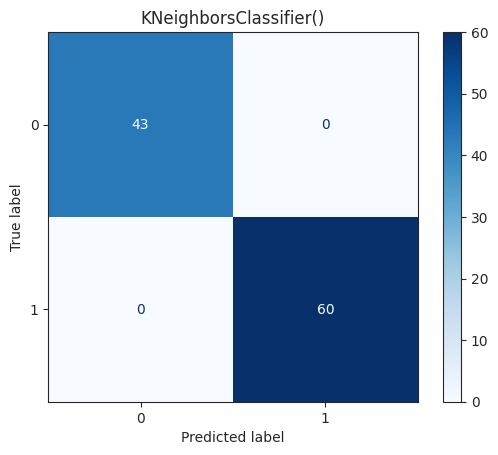

In [411]:
train_and_print(
    KNeighborsClassifier(),
    {
        "n_neighbors": [1, 2, 5, 8]
    },
    "recall"
)

Best params: {'estimator__var_smoothing': 100.0}
Best score: 0.9892701898878975


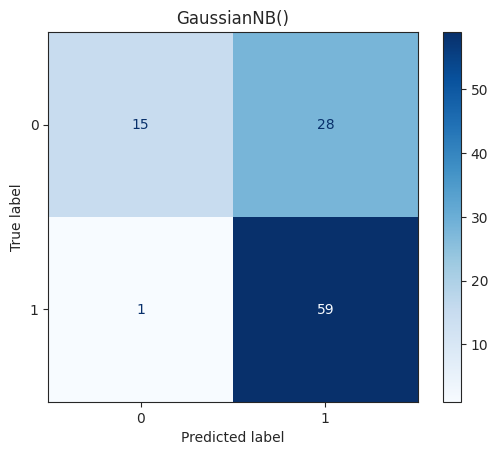

In [412]:
train_and_print(
    GaussianNB(),
    {
        "var_smoothing": [1e2, 1e1, 1, 1e-1]
    },
    "recall"
)

Best params: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_leaf_nodes': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0, 'estimator__splitter': 'random'}
Best score: 0.9956989247311828


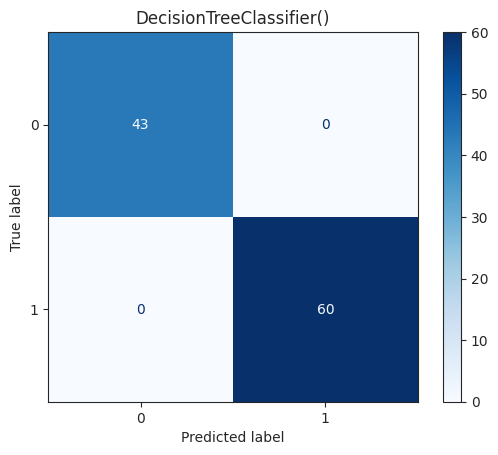

In [413]:
train_and_print(
    DecisionTreeClassifier(),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 100, 400],
        "min_samples_split": [2, 4],
        "min_samples_leaf": [1, 3],
        "min_weight_fraction_leaf": [0, 0.01, 0.1],
        "max_leaf_nodes": [None, 100, 400],
    },
    "recall"
)

## Вывод

Лучше всех себя показали алгоритмы DecisionTreeClassifier, GaussianNB, и обе реализации KNeighborsClassifier. Остальные реалиции тоже показали себя неплохо, но чуть хуже выше названных вариантов.